# Brief TAXI

A partir d'un jeu de données des taxis de New York nous allons essayer d'estimer le temps de trajet suivant plusieurs paramètres telle que la distance, le nombre de passagers, l'heure, le mois, la journée...


Nous allons commencer par calculer 4 indicateurs:
* la vitesse moyenne de chaque trajet (en km/h)
* le nombre de trajets effectués en fonction du jour de la semaine
* le nombre de trajets effectués en fonction de l’horaire de la journée par tranche de 4h.
* le nombre de km parcourus par jour de la semaine

## 1. Importation des données et configuration du data set

In [35]:
# %%script false --no-raise-error
# On importe les librairies dont on aura besoin pour ce tp
import warnings
warnings.filterwarnings("ignore")
from taxi_utils import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown
from IPython.display import display
from geopy.distance import geodesic
from math import radians, sin, cos, acos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


pd.set_option('display.float_format', lambda x: '%.3f' % x) #round float
plt.rcParams['figure.figsize'] = (8.5, 5)
plt.rcParams["patch.force_edgecolor"] = True
sns.mpl.rc("figure", figsize=(8.5,5))



# On charge les dataset en convertissant les colonnes de temps en valeurs de temps...
train_df = pd.read_csv('train.csv', parse_dates = [2, 3], nrows = 100000)
# test_df = pd.read_csv('test.csv', parse_dates = [2], nrows = None)
step("setup completed")

✅ *setup completed*

## Les colonnes

Pour caractériser chaque trajet de taxi on parlera de *course*.
Les données sont issues d'un logiciel à l'intéreieur des taxis qui log un certains nombres d'indicateurs, voici ces données (les colonnes):

* **id** : un identifiant unique pour chaque course
* **vendor_id** : le fournisseur du logiciel, il y en a deux 
* **pickup_datetime** : date et heure de départ de la course
* **dropoff_datetime** : date et heure d'arrivée de la course
* **passenger_count** : le nombre de passagers
* **pickup_longitude** : longitude du lieu de départ de la course
* **pickup_latitude** : latitude du lieu de départ de la course
* **dropoff_longitude** : longitude du lieu d'arrivée de la course
* **dropoff_latitude** : latitude du lieu d'arrivée de la course
* **store_and_fwd_flag** : indicateur Y(es)-N(o) précisant si l'enregistrement a d'abord été enregistrer dans la mémoire interne du taxi avant d'être envoyé au serveur car il n'y avait pas de connection.
* **trip_duration** : durée de la course en secondes

## Aperçu

In [36]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


## 2. Nettoyage des données

In [37]:
kv("Nombre de lignes dupliquées", train_df.duplicated().sum())
kv("Nombre de valeurs manquantes", train_df.isna().sum().sum())

**Nombre de lignes dupliquées** : 0

**Nombre de valeurs manquantes** : 0

In [38]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,100000.000,1.533,0.499,1.000,1.000,2.000,2.000,2.000
passenger_count,100000.000,1.668,1.318,0.000,1.000,1.000,2.000,6.000
pickup_longitude,100000.000,-73.973,0.038,-74.534,-73.992,-73.982,-73.967,-73.334
pickup_latitude,100000.000,40.751,0.028,40.434,40.737,40.754,40.768,41.319
dropoff_longitude,100000.000,-73.973,0.037,-74.562,-73.991,-73.980,-73.963,-72.711
dropoff_latitude,100000.000,40.752,0.032,40.442,40.736,40.754,40.770,41.312
trip_duration,100000.000,939.864,3004.541,1.000,396.000,662.000,1076.000,86390.000


In [39]:
# les boxplot si besoin
# train_df.boxplot(column=['pickup_latitude'])
# train_df.boxplot(column=['pickup_longitude'])
# train_df.boxplot(column=['dropoff_latitude'])
# train_df.boxplot(column=['dropoff_longitude'])

In [40]:
kv("passenger_count", "le nombre de passagers devrait être supérieur à 0")
kv("longitude et latitude", "La latitude devrait être entre 40.7128 et 40.748817 et la longitude entre 74.0059 et -73.968285")
kv("trip_duration", "La plus longue course  a durée 3526282 secondes soit env 980 heure, ce qui fausse complétement la distribution avec un écart type d'1h30 pour des course qui ne dépasse pas le périmètre d'une ville. On va considérer qu'une course ne doit pas dépasser 1h (3600s) et qu'elle doit durer au moins 2min (120)")

**passenger_count** : le nombre de passagers devrait être supérieur à 0

**longitude et latitude** : La latitude devrait être entre 40.7128 et 40.748817 et la longitude entre 74.0059 et -73.968285

**trip_duration** : La plus longue course  a durée 3526282 secondes soit env 980 heure, ce qui fausse complétement la distribution avec un écart type d'1h30 pour des course qui ne dépasse pas le périmètre d'une ville. On va considérer qu'une course ne doit pas dépasser 1h (3600s) et qu'elle doit durer au moins 2min (120)

In [41]:
train_df = train_df[train_df['passenger_count']>0]

train_df = train_df[train_df['pickup_longitude'] <= -73.75]
train_df = train_df[train_df['pickup_longitude'] >= -74.03]
train_df = train_df[train_df['pickup_latitude'] <= 40.85]
train_df = train_df[train_df['pickup_latitude'] >= 40.63]
train_df = train_df[train_df['dropoff_longitude'] <= -73.75]
train_df = train_df[train_df['dropoff_longitude'] >= -74.03]
train_df = train_df[train_df['dropoff_latitude'] <= 40.85]
train_df = train_df[train_df['dropoff_latitude'] >= 40.63]

train_df = train_df[train_df['trip_duration'] <= 3600]
train_df = train_df[train_df['trip_duration'] >= 120]

In [42]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,96062.000,1.534,0.499,1.000,1.000,2.000,2.000,2.000
passenger_count,96062.000,1.670,1.319,1.000,1.000,1.000,2.000,6.000
pickup_longitude,96062.000,-73.975,0.035,-74.025,-73.992,-73.982,-73.968,-73.756
pickup_latitude,96062.000,40.751,0.027,40.631,40.738,40.754,40.768,40.850
dropoff_longitude,96062.000,-73.974,0.031,-74.030,-73.991,-73.980,-73.964,-73.750
dropoff_latitude,96062.000,40.752,0.029,40.630,40.736,40.754,40.770,40.850
trip_duration,96062.000,815.190,571.036,120.000,405.000,663.000,1057.000,3600.000


**Vérification des types**

In [43]:
train_df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

In [44]:
step("Le jeu de données étant propre, on peut passer à l'étape suivante")

✅ *Le jeu de données étant propre, on peut passer à l'étape suivante*

## Feature Engineering

Les données temporelles sont exprimées sous la forme d'un datetime. Maisp pour utiliser nos données dans un modèle de machine learning on ne peut pas directement travaillé avec des datetime. De plus pour l'analyse on aimerait pouvoir effectuer des opérations avec les composants de la date : le mois, le jour de la semaine et l'heure. On va donc extraire du datetime ces trois informations.



In [45]:
# Extraction de la date et de l'heure
train_df['pickup_date'] = train_df['pickup_datetime'].dt.date
train_df['pickup_time'] = train_df['pickup_datetime'].dt.time
train_df['dropoff_date'] = train_df['dropoff_datetime'].dt.date
train_df['dropoff_time'] = train_df['dropoff_datetime'].dt.time

# Extraction du mois, du jour et de l'heure seulement sur pickup car nous ne voulons pas de doublons
train_df['pickup_month'] = train_df['pickup_datetime'].dt.month # Extract month
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour # Extract hour
train_df['pickup_weekday'] = train_df['pickup_datetime'].dt.dayofweek # Extract day of week

# Supression des anciennes colonnes
train_df.drop(['pickup_datetime'], axis = 1, inplace = True)
train_df.drop(['dropoff_datetime'], axis = 1, inplace = True)



### Calcul de la distance et de la vitesse moyenne

In [46]:

# def calc_speed(row):
#     time = row.trip_duration
#     start = (row.pickup_latitude, row.pickup_longitude)
#     end = (row.dropoff_latitude, row.dropoff_longitude)
#     distance = geodesic(start, end).kilometers
#     return distance/(time/3600)

def calc_distance(row):
    slat = radians(row['pickup_latitude'])
    slon = radians(row['pickup_longitude']) 
    elat = radians(row['dropoff_latitude'])
    elon = radians(row['dropoff_longitude'])
    value = sin(slat) * sin(elat) + cos(slat) * cos(elat)*cos(slon - elon)
    if value > 1 or value < -1:
        return np.nan
    else:
        dist = 6371.01 * acos(value)
        return dist
    
def calc_speed(row):
    return row.distance/(row.trip_duration/3600)
    


# train_df["speed_geopy_mean"] = train_df.apply(calc_speed, axis = 1)
train_df["distance"] = train_df.apply(calc_distance, axis = 1)
train_df["speed_mean"] = train_df.apply(calc_speed, axis = 1)
md("La distance a été calaculée de deux façons, par la formule mathématique et avec l'extension geopy")

La distance a été calaculée de deux façons, par la formule mathématique et avec l'extension geopy

In [47]:
train_df["distance"].describe()

count   96057.000
mean        3.252
std         3.473
min         0.000
25%         1.263
50%         2.095
75%         3.770
max        27.192
Name: distance, dtype: float64

New York mesure environ 22km de long et 4km de large. On peut considérer que les courses de plus de 22km ne sont pas pertinentes, le client a peut être changé d'avis au cours de la course ou a souhaité faire un détour, ce n'est pas représentatif. On écarte également les courses de moins de 100m.

In [48]:
print(train_df.shape)
train_df = train_df[train_df['distance'] >= 0.1]
train_df = train_df[train_df['distance'] <= 22]
print(train_df.shape)

(96062, 18)
(95450, 18)


In [49]:
train_df.sample()
step("Feature Engineering")

✅ *Feature Engineering*

In [50]:
train_df.sample()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_time,dropoff_date,dropoff_time,pickup_month,pickup_hour,pickup_weekday,distance,speed_mean
61698,id3459130,1,1,-73.989,40.736,-73.986,40.746,N,351,2016-01-20,08:18:31,2016-01-20,08:24:22,1,8,2,1.202,12.326


## Exploration

### La durée des trajets

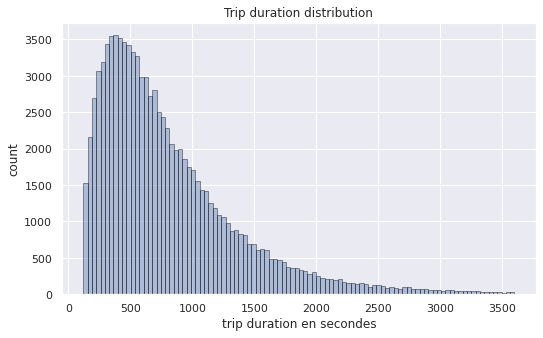

,count,mean,std,min,25%,50%,75%,max
trip_duration,95450.000,812.065,566.096,120.000,405.000,662.000,1054.000,3597.000


In [51]:
num_bins = 100
fig = plt.figure(figsize=(8.5, 5))
plt.hist(train_df['trip_duration'], num_bins, edgecolor = 'black', alpha = .40)


plt.xlabel('trip duration en secondes')
plt.ylabel('count')
plt.title("Trip duration distribution")
plt.show()

# Statistical summary
train_df.describe()[['trip_duration']].T

La plupart des courses durent entre 5 et 15min mais s'étalent jusqu'à 1h.

### Nombre de courses

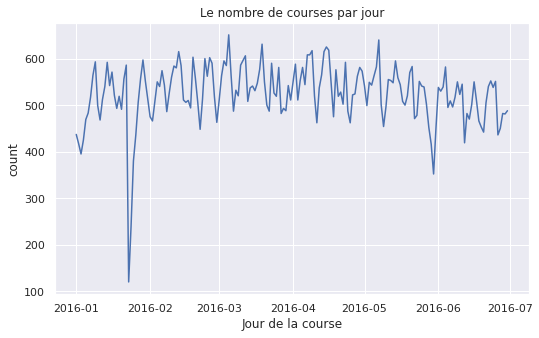

**moyenne** : 524 courses par jour

**min** : 120 courses par jour

**max** : 651 courses par jour

In [52]:
pickups_by_day = train_df.groupby('pickup_date').count()['id']

# Create graph
pickups_by_day.plot(x = 'pickup_date', figsize = (8.5,5))
plt.xlabel('Jour de la course')
plt.ylabel('count')
plt.title("Le nombre de courses par jour")
plt.show()

kv("moyenne", "{} courses par jour".format(round(pickups_by_day.mean())))
kv("min", "{} courses par jour".format(round(pickups_by_day.min())))
kv("max", "{} courses par jour".format(round(pickups_by_day.max())))

On observe une chute brutale du nombre de courses à la fin du mois de janvier. Cela concerne un événement météorologique exceptionnel qui a paralysé la ville :
https://www.lemonde.fr/planete/article/2016/01/23/une-puissante-tempete-de-neige-frappe-l-est-des-etats-unis_4852503_3244.html

### Zone d'activité

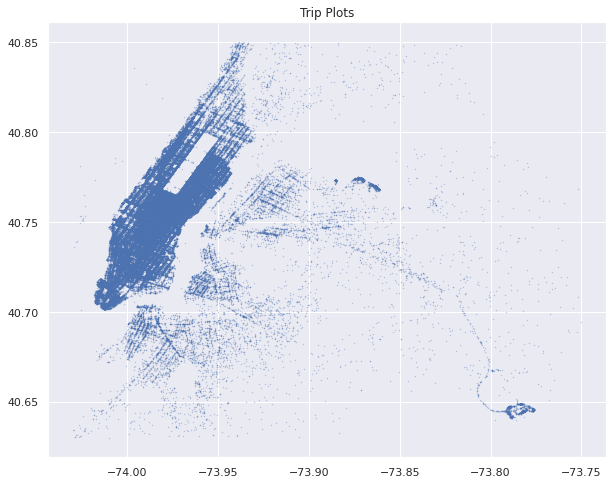

In [53]:
longitude = list(train_df.pickup_longitude) + list(train_df.dropoff_longitude)
latitude = list(train_df.pickup_latitude) + list(train_df.dropoff_latitude)
plt.figure(figsize = (10,8))
plt.plot(longitude,latitude,'.',alpha = .40, markersize = .8)
plt.title('Trip Plots')
plt.show()

On observe que l'activité se concentre principalement à Manhattan, ainsi que dans les deux aéroports

### Corrélations

Score de corrélation de la durée des courses avec les autres variables numériques:

distance: 0.7500072865341151
pickup_longitude: 0.3164811623329443
dropoff_longitude: 0.24539931089432848
pickup_latitude: -0.1908290508439796
dropoff_latitude: -0.17956333023732915
pickup_month: 0.057615303528574434
speed_mean: 0.03804829408332992
pickup_weekday: -0.03617887476342718
pickup_hour: 0.03592288319984459
passenger_count: 0.010554496347099759


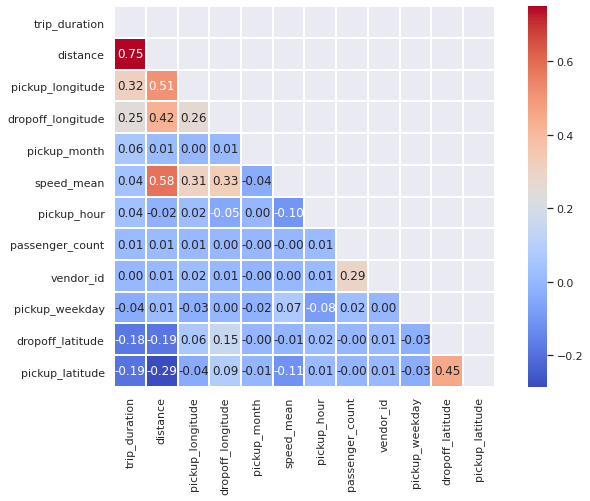

In [54]:
# Correlations to trip_duration
corr = train_df.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict = corr['trip_duration'].to_dict()
del cor_dict['trip_duration']
print("Score de corrélation de la durée des courses avec les autres variables numériques:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: {1}".format(*ele))
    
# Correlation matrix heatmap
corrmat = train_df.corr()
plt.figure(figsize=(12, 7))

# Number of variables for heatmap
k = 100
cols = corrmat.nlargest(k, 'trip_duration')['trip_duration'].index
cm = np.corrcoef(train_df[cols].values.T)

# Generate mask for upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1)
sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,\
                 fmt='.2f',annot_kws={'size': 12}, yticklabels=cols.values,\
                 xticklabels=cols.values, cmap = 'coolwarm',lw = .1)
plt.show() 

La durée des courses semblent dépendrent en grand partie de la distance (0.76) mais aussi du lieu traverssé (jusqu'à 0.53). D'autre part et assez logiquement la vitesse dépend de la distance mais pas du tout de la durée de la course. Les taxis ont une vitesse plus importantes sur les longs trajets car ils peuvent s'éloigner des zones ultra dense de Manhattan.

## Visualisations

## Vitesse moyenne des courses

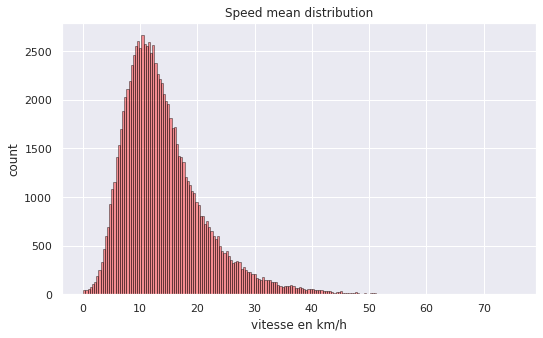

,count,mean,std,min,25%,50%,75%,max
speed_mean,95450.000,14.111,7.202,0.107,9.148,12.651,17.438,75.362


In [55]:

num_bins = 200
fig = plt.figure(figsize=(8.5, 5))
plt.hist(train_df['speed_mean'], num_bins, color = 'red', edgecolor = 'black', alpha = .40)
plt.xlabel('vitesse en km/h')
plt.ylabel('count')
plt.title("Speed mean distribution")
plt.show()
train_df.describe()[['speed_mean']].T

La vitesse moyenne est d'environ 14km/h, elle se situe majoritairement dans une fourchette allant de 5 à 20km/h, ce qui illustre le traffic important présent en ville.

## Nombre de courses effectuées en fonction du jour et de l'heure

### par jour de la semaine

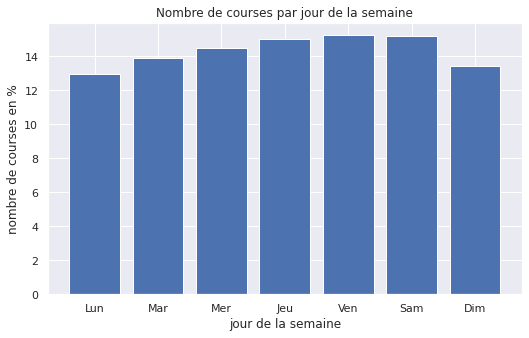

In [56]:
def dict_count_to_percent(d):
    total = sum(d.values())
    for k, v in d.items():
        d[k] = round((v / total)*100, 2)
    return d

df_count_by_day = train_df.groupby(train_df['pickup_weekday'])["id"].count()
df_count_by_day.index = ["Lun", "Mar", "Mer", "Jeu", "Ven", "Sam", "Dim"]
count_by_day_dict = dict_count_to_percent(df_count_by_day.to_dict())

plt.bar(count_by_day_dict.keys(), count_by_day_dict.values())
plt.xlabel('jour de la semaine')
plt.ylabel('nombre de courses en %')
plt.title("Nombre de courses par jour de la semaine")
plt.show()

Le jour de la semaine ne semble pas influencer le nombre de courses

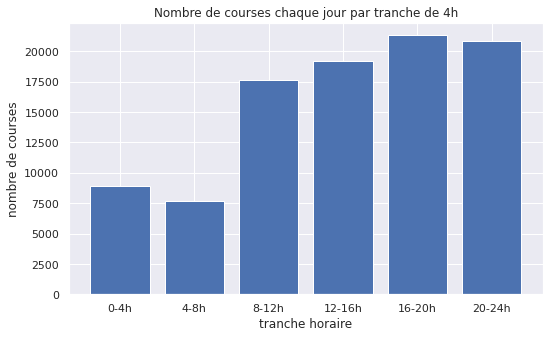

In [57]:
res = []
# get count for each hour
select_count_by_hour = train_df.groupby(train_df['pickup_hour']).count()['id']

# now we must convert each hour to 4 hours interval, (not the simplest way)
total = 0
count_by_hour_dict = {}
tranches = ["0-4h", "4-8h", "8-12h", "12-16h", "16-20h", "20-24h"]
for i in range(1,25):
    total += select_count_by_hour[i-1]
    if i%4 == 0:
        tranche = tranches[int(i/4-1)]
        count_by_hour_dict[tranche] = total
        total = 0


plt.bar(count_by_hour_dict.keys(), count_by_hour_dict.values())
plt.xlabel('tranche horaire')
plt.ylabel('nombre de courses')
plt.title("Nombre de courses chaque jour par tranche de 4h")
plt.show()

Il y a plus de course lors des horaires de travail puis en soirée.

In [58]:
def heatmap_calendar_weeks(data, title, detail):
    # Trips by Hour and Day of Week
    plt.figure(figsize=(18,10))
    hourday_graph = sns.heatmap(data,
                                       lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
    # Customize tick label size
    hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

    # Customize tick labels of the y-axis
    hourday_graph.set_xticklabels(labels = ['Lun', 'Mar', 'Mer','Jeu','Ven','Sam','Dim'])

    # Bolding horizontal line at y = 0
    hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

    # Remove the label of the x-axis
    hourday_graph.xaxis.label.set_visible(False) 

    # # Adding a title and a subtitle
    hourday_graph.text(x =-.8, y = 27, s = title,
                   fontsize =20 , weight = 'bold', alpha = .90)
    hourday_graph.text(x =-.8, y = 28.5, 
                   s = detail,
                  fontsize = 14, alpha = .85)

    plt.show() 

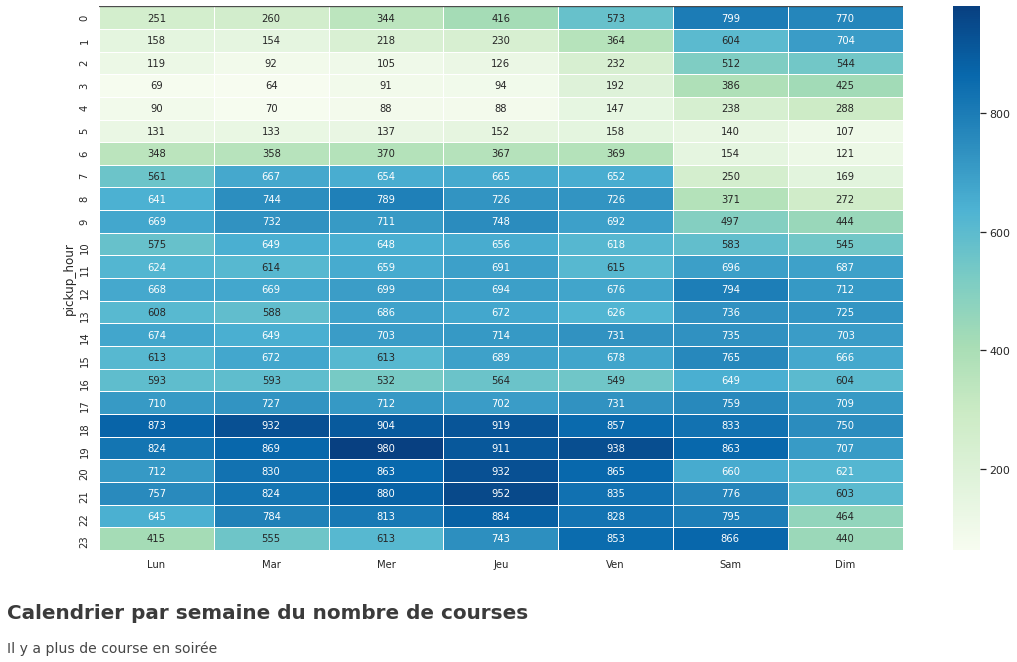

In [59]:
heatmap_calendar_weeks(
    data = train_df.groupby(['pickup_hour','pickup_weekday'])['id'].count().unstack(),
    title = "Calendrier par semaine du nombre de courses",
    detail = "Il y a plus de course en soirée"
)

On observe que les taxis, comme la ville, ne dorment jamais.

## Nombre de km parcourus par jour de la semaine

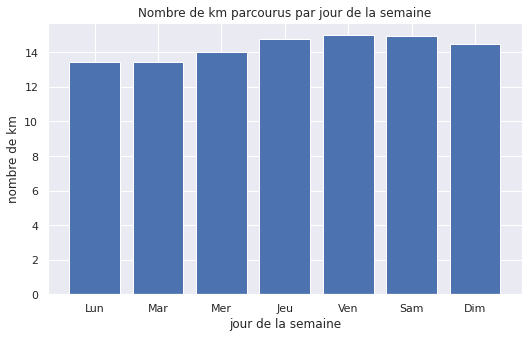

In [80]:
df_distance_by_day = train_df.groupby(train_df['pickup_weekday']).distance.sum()
df_distance_by_day.index = ["Lun", "Mar", "Mer", "Jeu", "Ven", "Sam", "Dim"]
distance_by_day_dict = dict_count_to_percent(df_distance_by_day.to_dict())

plt.bar(distance_by_day_dict.keys(), distance_by_day_dict.values())
plt.xlabel('jour de la semaine')
plt.ylabel('nombre de km')
plt.title("Nombre de km parcourus par jour de la semaine")
plt.show()

La taxi font un peu moins de kilomètres le lundi et mardi, peut être parcequ'il y a moins de trajets à l'aéroport.

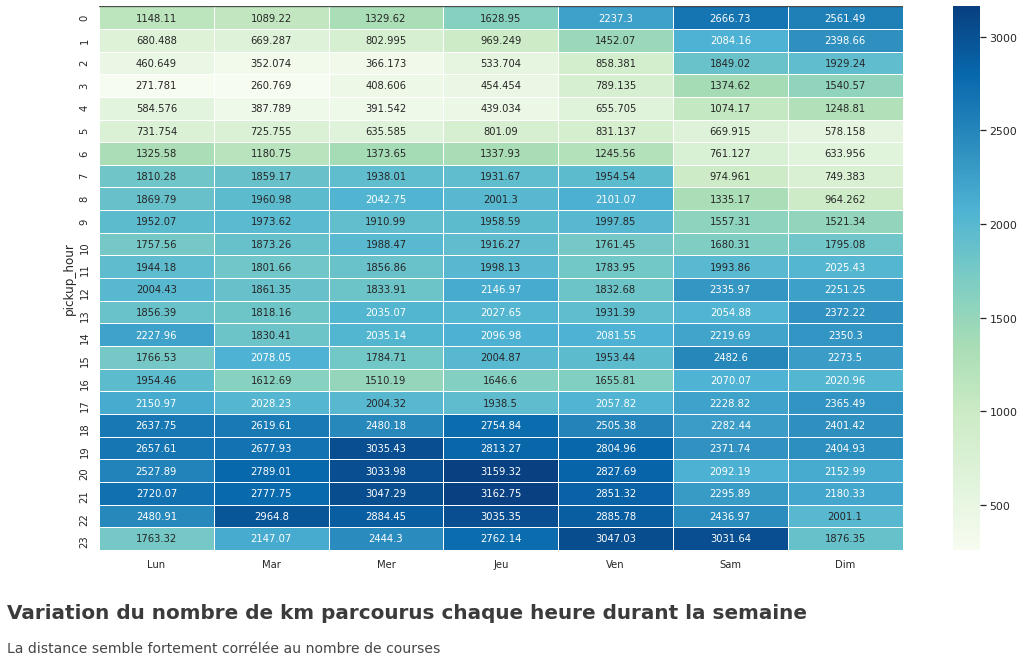

In [61]:
heatmap_calendar_weeks(
    data = train_df.groupby(['pickup_hour','pickup_weekday'])['distance'].sum().unstack(),
    title = "Variation du nombre de km parcourus chaque heure durant la semaine",
    detail = "La distance semble fortement corrélée au nombre de courses"
)

## 3. Machine learning

In [62]:
df = train_df.copy()

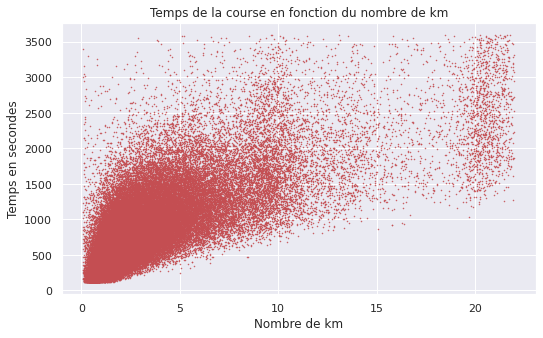

In [63]:
# On affiche le nuage de points dont on dispose
plt.plot(df['distance'], df['trip_duration'], 'ro', markersize=0.5)
plt.xlabel('Nombre de km')
plt.ylabel('Temps en secondes')
plt.title("Temps de la course en fonction du nombre de km")
plt.show()

## 4. Choix du modèle de machine learning

Clairement, d'après la visualisation, on peut se dire que le temps de trajet dépend de la distance de sorte que l'on pourrait tracer une droite montrant le temps minimum qu'il faut pour parcourir une distance donnée. Cependant au dessus de cette droite on observe un amas de points montrant que le temps de trajet peut s'allonger en étant influencé par d'autres variables comme on pourrait le penser, l'heure, le traffic, la météo...

## 5. Préparation des données

### 5.a échantillonage

In [64]:

df.shape

(95450, 18)

In [65]:
# Le jeu de données étant grand, on réaliser l'apprentissage sur un échantillon

df = df.sample(n=10000)

### 5.b Sélection de la variable cible et des variables à explicatives

On peut voir que lorsque la surface devient un peu trop grande, les données semblent devenir moins modélisables facilement, il y a plus de variabilité. On va considérer pour l'instant résoudre le problème de prédiction pour les loyers inférieurs à 10,000€, afin de conserver une robustesse du modèle à ces données plutôt anormales, qui correspondent peut-être à un autre modèle distinct ou à un traitement comme outliers.


In [66]:
# df = df[df['loyer'] < 10000]

On définit à présent notre variable cible

In [67]:
y = df.trip_duration

Ainsi que nos variables explicatives (qui est ici unique)

In [68]:
X = df[["distance"]]

## 6. Division du jeu de données en training/validation/testing sets

In [69]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

## 8. Apprentissage sur le training set

#### On implémente la regression linéaire

In [70]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(xtrain, ytrain)

LinearRegression()

#### On obtient ainsi les parmètres β1 et β0 de notre modèle

In [71]:
def to_minute(second):
    m = int(second//60)
    s = round(second % m)
    return "{}min{}s".format(m, s) if s>0 else "{}min".format(m)


print("Le coefficient β1 est égal à {} tandis que l'intercept β0 est égal à {}"
      .format(round(regr.coef_[0],2),round(regr.intercept_)))

print("\n")

print("On comprend donc que tous les trajet dure au moins {} auquel il faut ajouter {} par km"
     .format(to_minute(regr.intercept_),to_minute(regr.coef_[0])))

Le coefficient β1 est égal à 128.07 tandis que l'intercept β0 est égal à 406


On comprend donc que tous les trajet dure au moins 6min4s auquel il faut ajouter 2min par km


#### On peut à présent réaliser des prédictions

In [72]:
x_to_predict = 5
x_df =  pd.DataFrame({'distance': [x_to_predict]})

print("Selon le modèle, il faut {} pour parcourir {}km"
      .format(to_minute(regr.predict(x_df)[0]), x_to_predict))

print("\n")

print ("On remarque que {} * {} + {} = {}"
       .format(x_to_predict,round(regr.coef_[0],2),round(regr.intercept_),
               x_to_predict*round(regr.coef_[0],2)+round(regr.intercept_)))

Selon le modèle, il faut 17min10s pour parcourir 5km


On remarque que 5 * 128.07 + 406 = 1046.35


#### enfin on peut représenter notre modèle linéaire

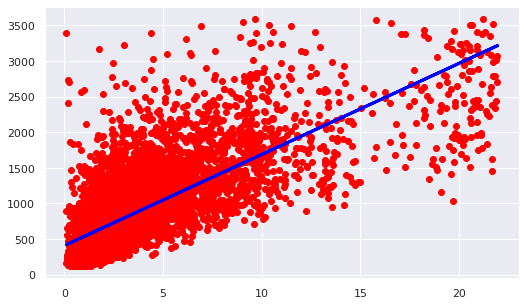

In [73]:
ytrainpred = regr.predict(xtrain)


# Plot outputs
plt.scatter(xtrain, ytrain,  color='red')
plt.plot(xtrain, ytrainpred, color='blue', linewidth=3)

plt.show()

## 8. Evaluation du modèle sur le testing set

In [74]:
from sklearn.metrics import mean_squared_error, r2_score

#### évaluation à partir du R2

In [75]:
ytrainpred = regr.predict(xtrain)
ytestpred = regr.predict(xtest)

print ("Pour les données d'entrainement le R2 vaut {} alors que pour les données de test, il est de {}" 
      .format(round(r2_score(ytrain, ytrainpred),3), round(r2_score(ytest, ytestpred),3)))



Pour les données d'entrainement le R2 vaut 0.562 alors que pour les données de test, il est de 0.583


Le coefficient de détermination R2 est éloigné de 1 , le modèle de regression linéaire est donc moyen. Les R2 des jeux d'entrainement et de test sont proche, le modèle est donc robuste.

#### évaluation à partir du RMSE

In [76]:
print ("Pour les données d'entrainement le RMSE vaut {} alors que pour les données de test, il est de {}" 
      .format(round(mean_squared_error(ytrain, ytrainpred, squared=False),3), 
              round(mean_squared_error(ytest, ytestpred, squared=False),3)))

Pour les données d'entrainement le RMSE vaut 383.78 alors que pour les données de test, il est de 364.216


A nouveau on remarque qu'il y a peu de perte entre les deux modèles

#### évaluation graphique

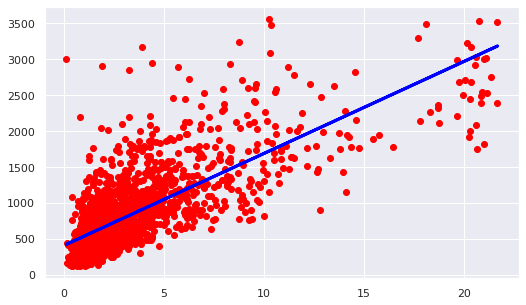

In [77]:
# Plot outputs
plt.scatter(xtest, ytest,  color='red')
plt.plot(xtest, ytestpred, color='blue', linewidth=3)

plt.show()

La droite marque une tendance qui a du sens mais l'épaisseur du nage de points en dessous et au dessus de la doite montre qu'elle ne permettra pas d'obtenir une prédiction fiable.

Remarque: Les résultats peuvent être meilleurs pour l'échantillon de test que dans celui de train, ce résultat est assez exeptionnel et est due au fait que l'aléa à classer dans l'échantillon de train des données fortement équartée du nuage de point, ainsi ces quelques données suffisent à dégrader le R2 de l'échantillon d'entrainement.

In [78]:
md("On voit bien que la distance n'est pas la seule variable qui doit influencer le temps de trajet, voyons comment l'on peut incorporer la position géographique dans une analyse multivariée")

On voit bien que la distance n'est pas la seule variable qui doit influencer le temps de trajet, voyons comment l'on peut incorporer la position géographique dans une analyse multivariée

### Régression linéaire multivariée

In [81]:
df.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday', 'distance', 'speed_mean'],
      dtype='object')

In [95]:
# On choisis d'inclure la longitud et la latitude
from sklearn import metrics
def multi_reg(df, X_cols, y_col, reports):
#     print("Regression linéaire pour prédire la valeure de {} à partir des variables suivantes : {}".format(y_col, X_cols))
    X = df[X_cols]
    y = df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    lreg = LinearRegression()
    lreg.fit(X_train,y_train)
    y_pred_lreg = lreg.predict(X_test)
    report = {}
    print(X_cols)
    report['X'] = X_cols
    report['R^2='] = metrics.explained_variance_score(y_test,y_pred_lreg)
    report['MAE'] = metrics.mean_absolute_error(y_test,y_pred_lreg)
    report['MSE'] = metrics.mean_squared_error(y_test,y_pred_lreg)
    report['RMSE'] = np.sqrt(metrics.mean_squared_error(y_test,y_pred_lreg))
    reports.append(report)

X_cols = ["distance", "pickup_longitude", "pickup_latitude", "speed_mean", "pickup_month", "pickup_weekday", "pickup_hour"]
y = "trip_duration"

md("**Univarié**")
reports = []
for X in X_cols:
    multi_reg(df, [X], y, reports)
    
display(pd.DataFrame(reports))
    
md("**Multivarié**")
reports = []
multi_X = []
for X in X_cols:
    multi_X.append(X)
    multi_reg(df, multi_X, y, reports)

display(pd.DataFrame(reports))




**Univarié**

['distance']
['pickup_longitude']
['pickup_latitude']
['speed_mean']
['pickup_month']
['pickup_weekday']
['pickup_hour']


,X,R^2=,MAE,MSE,RMSE
0,[distance],0.591,268.808,138059.743,371.564
1,[pickup_longitude],0.106,413.504,301953.367,549.503
2,[pickup_latitude],0.035,429.799,325668.580,570.674
3,[speed_mean],0.004,432.661,336371.433,579.975
4,[pickup_month],0.003,432.852,336484.544,580.073
5,[pickup_weekday],0.004,432.438,336261.565,579.881
6,[pickup_hour],0.001,432.947,337289.142,580.766


**Multivarié**

['distance']
['distance', 'pickup_longitude']
['distance', 'pickup_longitude', 'pickup_latitude']
['distance', 'pickup_longitude', 'pickup_latitude', 'speed_mean']
['distance', 'pickup_longitude', 'pickup_latitude', 'speed_mean', 'pickup_month']
['distance', 'pickup_longitude', 'pickup_latitude', 'speed_mean', 'pickup_month', 'pickup_weekday']
['distance', 'pickup_longitude', 'pickup_latitude', 'speed_mean', 'pickup_month', 'pickup_weekday', 'pickup_hour']


,X,R^2=,MAE,MSE,RMSE
0,"[distance, pickup_longitude, pickup_latitude, ...",0.591,268.808,138059.743,371.564
1,"[distance, pickup_longitude, pickup_latitude, ...",0.596,265.513,136447.604,369.388
2,"[distance, pickup_longitude, pickup_latitude, ...",0.596,265.478,136323.731,369.220
3,"[distance, pickup_longitude, pickup_latitude, ...",0.811,165.321,63716.425,252.421
4,"[distance, pickup_longitude, pickup_latitude, ...",0.812,165.861,63568.664,252.128
5,"[distance, pickup_longitude, pickup_latitude, ...",0.812,165.671,63456.667,251.906
6,"[distance, pickup_longitude, pickup_latitude, ...",0.812,165.690,63453.637,251.900
